Saving 26.txt to 26.txt
Saving 16.txt to 16.txt
[1.2932333812233752, 0.30457085085066743, -0.4994930768733178, -2.254855011648329, -2.404138433602749, -0.929954438850416, -0.7295488589801964, -0.9108680987659865, -0.40053776703514476, -0.03052188514845036, 0.3064920405291244, 1.7891349474627083, 2.044068549659503, 2.5546462443035454, 1.4688629172624794, 1.3199612770110674, -0.5003568545572906, -0.8823379085650727, -2.180416924496456, -2.9011339351443093, -1.002585489387907, -1.615889143922282, -0.8429914626648787, -0.7487501712273986, 0.48300900552977577, 1.0557631013295183, 1.9774283590625839, 1.1628107924710391, 2.1451103228284647, 1.3027335867069298, 2.0650966324181548, 0.15314877003729976, 0.1778096248505628, 0.004715967686841682, -1.4259964177307394, -1.2465333796496887, -1.5142997321970624, -1.2313735552412588, -0.6125107585746713, -0.5767424644698419, 1.1352371215658306, 0.2942316463148081, 1.3302326145131842, 1.9890698744557844, 2.0027440538955203, 1.9785211523495865, 1.6876420

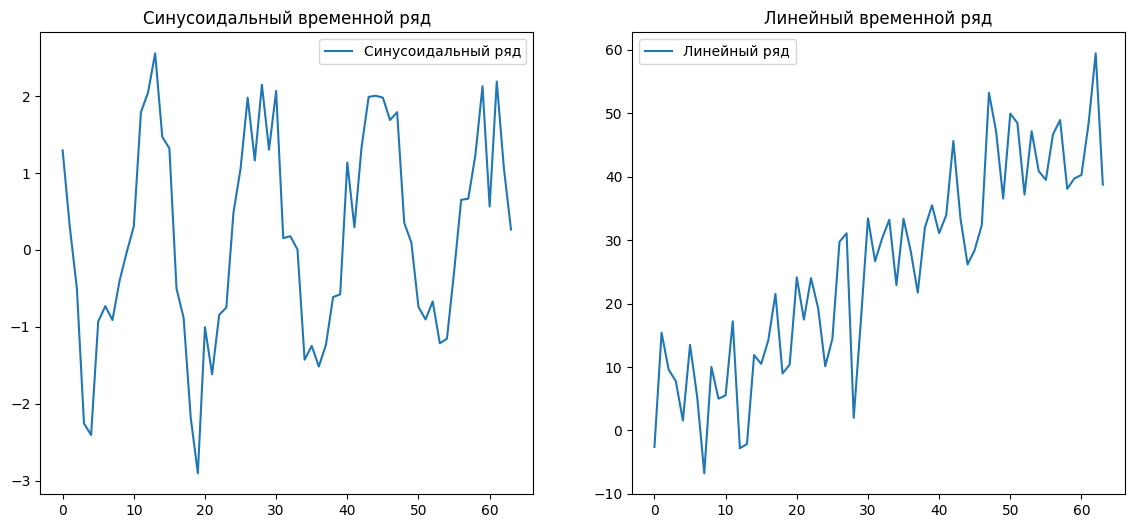

In [2]:
from google.colab import files
files.upload()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import linregress

with open('16.txt', 'r') as file:
    data1 = file.readlines()
    data1 = [float(line.strip()) for line in data1]
print(data1)

with open('26.txt', 'r') as file:
    data2 = file.read().splitlines()
    data2 = [float(line) for line in data2]
print(data2)

df1 = pd.DataFrame(data1, columns=['Value'])
df2 = pd.DataFrame(data2, columns=['Value'])

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(df1['Value'], label='Синусоидальный ряд')
plt.title("Синусоидальный временной ряд")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(df2['Value'], label='Линейный ряд')
plt.title("Линейный временной ряд")
plt.legend()
plt.show()


Лучшее окно для SMA (синусоидальный ряд): 7 Q-статистика: 26.096859004117377
Лучшее окно для SMA (линейный ряд): 19 Q-статистика: 34.37367338782326
Дарбин-Уотсон (синусоидальный ряд, SMA): 1.4375764935269875
Дарбин-Уотсон (линейный ряд, SMA): 1.9262438220686682


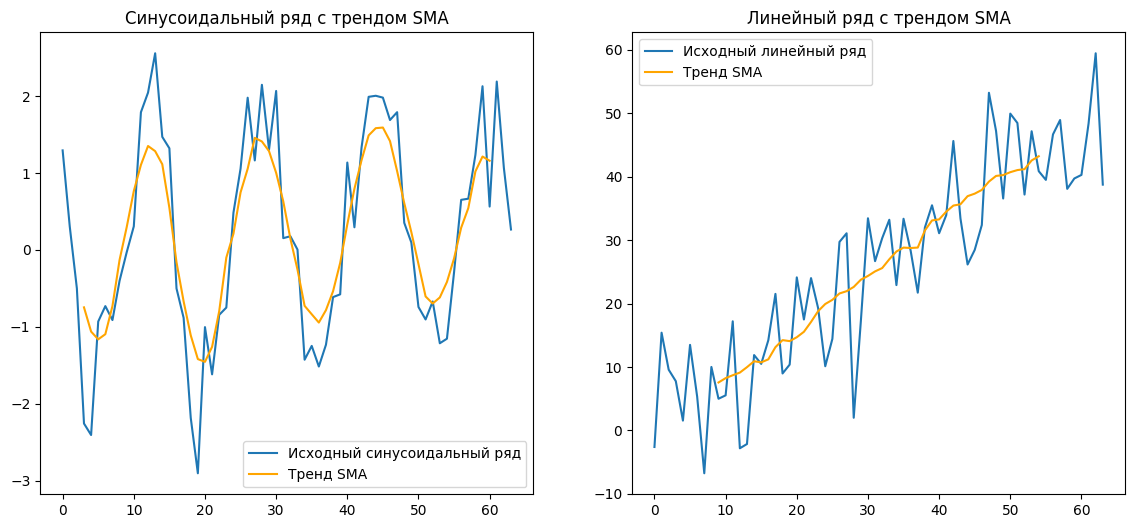

In [3]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson

def simple_moving_average(data, window):
    return data.rolling(window=window, center=True).mean()

def optimize_sma(data, m_values):
    best_window = None
    best_q_stat = float('inf')

    for m in m_values:
        window = 2 * m + 1
        trend = simple_moving_average(data, window)
        residuals = data - trend
        q_stat = acorr_ljungbox(residuals.dropna(), lags=5, return_df=True)['lb_stat'].sum()

        if q_stat < best_q_stat:
            best_q_stat = q_stat
            best_window = window

    return best_window, best_q_stat

best_window1, q_stat1 = optimize_sma(df1['Value'], [3, 5, 7, 9])
print("Лучшее окно для SMA (синусоидальный ряд):", best_window1, "Q-статистика:", q_stat1)

best_window2, q_stat2 = optimize_sma(df2['Value'], [3, 5, 7, 9])
print("Лучшее окно для SMA (линейный ряд):", best_window2, "Q-статистика:", q_stat2)
trend_sma1 = simple_moving_average(df1['Value'], best_window1)
residuals_sma1 = df1['Value'] - trend_sma1
trend_sma2 = simple_moving_average(df2['Value'], best_window2)
residuals_sma2 = df2['Value'] - trend_sma2
dw_stat1 = durbin_watson(residuals_sma1.dropna())
dw_stat2 = durbin_watson(residuals_sma2.dropna())
print("Дарбин-Уотсон (синусоидальный ряд, SMA):", dw_stat1)
print("Дарбин-Уотсон (линейный ряд, SMA):", dw_stat2)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(df1['Value'], label='Исходный синусоидальный ряд')
plt.plot(trend_sma1, label='Тренд SMA', color='orange')
plt.legend()
plt.title("Синусоидальный ряд с трендом SMA")

plt.subplot(1, 2, 2)
plt.plot(df2['Value'], label='Исходный линейный ряд')
plt.plot(trend_sma2, label='Тренд SMA', color='orange')
plt.legend()
plt.title("Линейный ряд с трендом SMA")
plt.show()

Лучшее окно для WMA (синусоидальный ряд): 7 Q-статистика: 98.03465264234914
Лучшее окно для WMA (линейный ряд): 19 Q-статистика: 23.983206361452794
Дарбин-Уотсон (синусоидальный ряд, WMA): 0.9320321231514754
Дарбин-Уотсон (линейный ряд, WMA): 1.1989110834757126


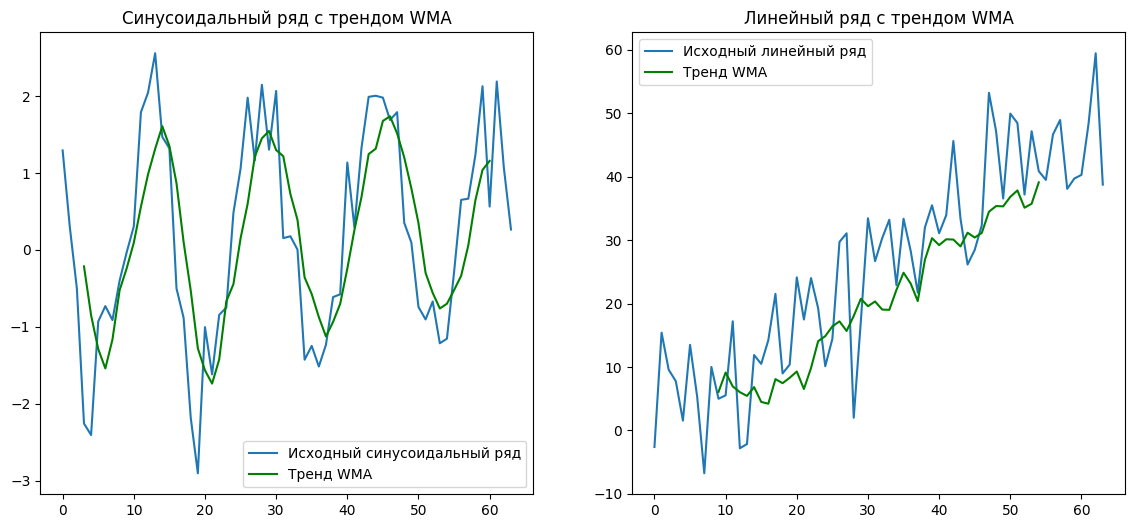

In [4]:
def weighted_moving_average(data, window, epsilon=0.3):
    weights = np.exp(-epsilon * np.arange(window))
    weights /= weights.sum()
    return data.rolling(window=window, center=True).apply(lambda x: np.dot(x, weights), raw=True)

def optimize_wma(data, m_values):
    best_window = None
    best_q_stat = float('inf')

    for m in m_values:
        window = 2 * m + 1
        trend = weighted_moving_average(data, window)
        residuals = data - trend
        q_stat = acorr_ljungbox(residuals.dropna(), lags=5, return_df=True)['lb_stat'].sum()

        if q_stat < best_q_stat:
            best_q_stat = q_stat
            best_window = window

    return best_window, best_q_stat

best_window1, q_stat1 = optimize_wma(df1['Value'], [3, 5, 7, 9])
print("Лучшее окно для WMA (синусоидальный ряд):", best_window1, "Q-статистика:", q_stat1)

best_window2, q_stat2 = optimize_wma(df2['Value'], [3, 5, 7, 9])
print("Лучшее окно для WMA (линейный ряд):", best_window2, "Q-статистика:", q_stat2)

trend_wma1 = weighted_moving_average(df1['Value'], best_window1)
residuals_wma1 = df1['Value'] - trend_wma1
trend_wma2 = weighted_moving_average(df2['Value'], best_window2)
residuals_wma2 = df2['Value'] - trend_wma2

dw_stat1 = durbin_watson(residuals_wma1.dropna())
dw_stat2 = durbin_watson(residuals_wma2.dropna())
print("Дарбин-Уотсон (синусоидальный ряд, WMA):", dw_stat1)
print("Дарбин-Уотсон (линейный ряд, WMA):", dw_stat2)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(df1['Value'], label='Исходный синусоидальный ряд')
plt.plot(trend_wma1, label='Тренд WMA', color='green')
plt.legend()
plt.title("Синусоидальный ряд с трендом WMA")

plt.subplot(1, 2, 2)
plt.plot(df2['Value'], label='Исходный линейный ряд')
plt.plot(trend_wma2, label='Тренд WMA', color='green')
plt.legend()
plt.title("Линейный ряд с трендом WMA")
plt.show()

Лучший span для EMA (синусоидальный ряд): 3 Q-статистика: 154.47556370694653
Лучший span для EMA (линейный ряд): 9 Q-статистика: 41.10442761469754
Дарбин-Уотсон (синусоидальный ряд, EMA): 0.952389330145618
Дарбин-Уотсон (линейный ряд, EMA): 1.6568257423473898


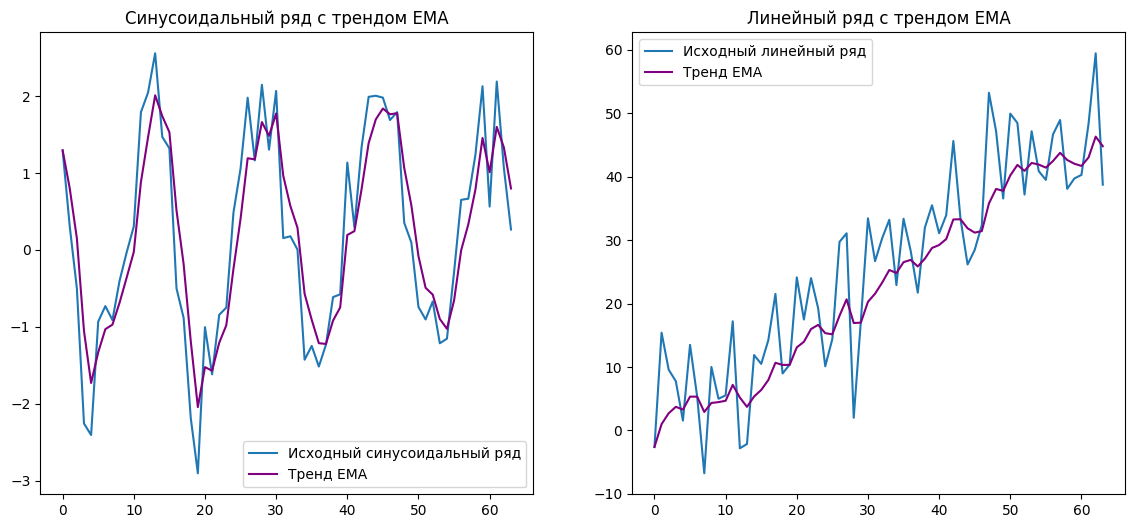

In [5]:
def exponential_moving_average(data, span):
    return data.ewm(span=span, adjust=False).mean()

def optimize_ema(data, span_values):
    best_span = None
    best_q_stat = float('inf')

    for span in span_values:
        trend = exponential_moving_average(data, span)
        residuals = data - trend
        q_stat = acorr_ljungbox(residuals.dropna(), lags=5, return_df=True)['lb_stat'].sum()

        if q_stat < best_q_stat:
            best_q_stat = q_stat
            best_span = span

    return best_span, best_q_stat

best_span1, q_stat1 = optimize_ema(df1['Value'], [3, 5, 7, 9])
print("Лучший span для EMA (синусоидальный ряд):", best_span1, "Q-статистика:", q_stat1)

best_span2, q_stat2 = optimize_ema(df2['Value'], [3, 5, 7, 9])
print("Лучший span для EMA (линейный ряд):", best_span2, "Q-статистика:", q_stat2)

trend_ema1 = exponential_moving_average(df1['Value'], best_span1)
residuals_ema1 = df1['Value'] - trend_ema1
trend_ema2 = exponential_moving_average(df2['Value'], best_span2)
residuals_ema2 = df2['Value'] - trend_ema2

dw_stat1 = durbin_watson(residuals_ema1.dropna())
dw_stat2 = durbin_watson(residuals_ema2.dropna())
print("Дарбин-Уотсон (синусоидальный ряд, EMA):", dw_stat1)
print("Дарбин-Уотсон (линейный ряд, EMA):", dw_stat2)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(df1['Value'], label='Исходный синусоидальный ряд')
plt.plot(trend_ema1, label='Тренд EMA', color='purple')
plt.legend()
plt.title("Синусоидальный ряд с трендом EMA")

plt.subplot(1, 2, 2)
plt.plot(df2['Value'], label='Исходный линейный ряд')
plt.plot(trend_ema2, label='Тренд EMA', color='purple')
plt.legend()
plt.title("Линейный ряд с трендом EMA")
plt.show()

Лучший span для DEMA (синусоидальный ряд): 3 Q-статистика: 26.232760320734066
Лучший span для DEMA (линейный ряд): 9 Q-статистика: 47.51622466305464
Дарбин-Уотсон (синусоидальный ряд, DEMA): 1.740981389419374
Дарбин-Уотсон (линейный ряд, DEMA): 2.0543223694624992


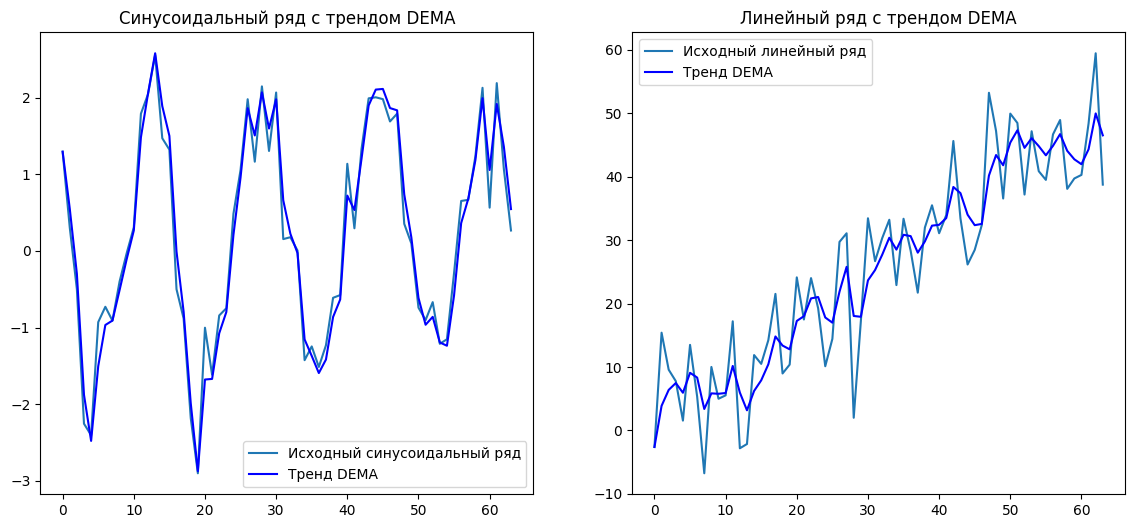

In [6]:
def double_exponential_moving_average(data, span):
    ema1 = data.ewm(span=span, adjust=False).mean()
    ema2 = ema1.ewm(span=span, adjust=False).mean()
    return 2 * ema1 - ema2

def optimize_dema(data, span_values):
    best_span = None
    best_q_stat = float('inf')

    for span in span_values:
        trend = double_exponential_moving_average(data, span)
        residuals = data - trend
        q_stat = acorr_ljungbox(residuals.dropna(), lags=5, return_df=True)['lb_stat'].sum()

        if q_stat < best_q_stat:
            best_q_stat = q_stat
            best_span = span

    return best_span, best_q_stat

best_span1, q_stat1 = optimize_dema(df1['Value'], [3, 5, 7, 9])
print("Лучший span для DEMA (синусоидальный ряд):", best_span1, "Q-статистика:", q_stat1)

best_span2, q_stat2 = optimize_dema(df2['Value'], [3, 5, 7, 9])
print("Лучший span для DEMA (линейный ряд):", best_span2, "Q-статистика:", q_stat2)

trend_dema1 = double_exponential_moving_average(df1['Value'], best_span1)
residuals_dema1 = df1['Value'] - trend_dema1
trend_dema2 = double_exponential_moving_average(df2['Value'], best_span2)
residuals_dema2 = df2['Value'] - trend_dema2

dw_stat1 = durbin_watson(residuals_dema1.dropna())
dw_stat2 = durbin_watson(residuals_dema2.dropna())
print("Дарбин-Уотсон (синусоидальный ряд, DEMA):", dw_stat1)
print("Дарбин-Уотсон (линейный ряд, DEMA):", dw_stat2)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(df1['Value'], label='Исходный синусоидальный ряд')
plt.plot(trend_dema1, label='Тренд DEMA', color='blue')
plt.legend()
plt.title("Синусоидальный ряд с трендом DEMA")

plt.subplot(1, 2, 2)
plt.plot(df2['Value'], label='Исходный линейный ряд')
plt.plot(trend_dema2, label='Тренд DEMA', color='blue')
plt.legend()
plt.title("Линейный ряд с трендом DEMA")
plt.show()